This notebook is for evaluating FHV taxi data for use in busyness data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os

In [2]:
# TODO: Iterate over the whole file
# Options:
# Do it with pyarrow slice by slice
parquet_file = "all_fhv_tripdata.parquet"
parquet_reader = pq.ParquetFile(parquet_file)


In [3]:
print(parquet_reader.schema.names)

['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime', 'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number']


In [4]:
# Remove unwanted columns
table = pq.read_table(parquet_file)
filtered_table = table.drop(['dispatching_base_num', 'SR_Flag', 'Affiliated_base_number'])
pq.write_table(filtered_table, "all_fhv_tripdata_filtered.parquet")

In [5]:
parquet_file = "all_fhv_tripdata_filtered.parquet"
parquet_reader = pq.ParquetFile(parquet_file)

In [ ]:
table = pq.read_table(parquet_file)
df = table.to_pandas()


In [ ]:
df.columns

Index(['pickup_datetime', 'dropOff_datetime', 'PUlocationID', 'DOlocationID'], dtype='object')

In [ ]:
num_rows = parquet_reader.metadata.num_rows
num_row_groups = parquet_reader.num_row_groups
# df.shape[0]
print(num_rows)

49111129


In [ ]:
print("Number of rows:", num_rows)
print("Number of cols:", df.shape[1])
print("Data types:") 
print(df.dtypes)

Number of rows: 49111129
Number of cols: 4
Data types:
pickup_datetime     datetime64[us]
dropOff_datetime    datetime64[us]
PUlocationID               float64
DOlocationID               float64
dtype: object


In [ ]:
df.head()

,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID
0,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN
1,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN
2,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN
3,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0
4,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0


In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
pickup_datetime,49111129,2022-08-28 20:49:03.576095,2021-01-01 00:00:00,2021-11-01 20:46:33,2022-08-31 07:58:00,2023-07-03 19:13:17,2024-03-31 23:59:57,NaN
dropOff_datetime,49111129,2022-08-28 21:24:30.542736,1917-09-10 21:28:24.290449,2021-11-01 21:12:24,2022-08-31 08:27:00,2023-07-03 20:10:17,2031-05-01 16:00:04,NaN
PUlocationID,10480257.0,136.63821,1.0,74.0,137.0,206.0,265.0,75.378251
DOlocationID,41267339.0,135.887925,1.0,69.0,132.0,213.0,265.0,79.919371


To save space, drop unneeded columns before analysis

In [ ]:
df.columns

Index(['pickup_datetime', 'dropOff_datetime', 'PUlocationID', 'DOlocationID'], dtype='object')

In [ ]:
print("Number of duplicate rows:", df[df.duplicated()==True].shape[0])

Number of duplicate rows: 1833610


In [ ]:
category_columns = ['PUlocationID', 'DOlocationID']
for column in category_columns:
    df[column] = df[column].astype('category')

In [ ]:
# Numeric
numeric_columns = df.select_dtypes(['int64', 'float64', 'datetime64']).columns

In [ ]:
# Get cardinality of the numeric columns
numeric_columns_card = df[numeric_columns].nunique()
df_numeric_card = pd.DataFrame(numeric_columns_card, columns=['card'])
df_numeric_card

,card
pickup_datetime,33227791
dropOff_datetime,33507864


In [ ]:
# First describe the numeric features
df_table_numeric = df[numeric_columns].describe().T
df_table_numeric

,count,mean,min,25%,50%,75%,max
pickup_datetime,49111129,2022-08-28 20:49:03.576095,2021-01-01 00:00:00,2021-11-01 20:46:33,2022-08-31 07:58:00,2023-07-03 19:13:17,2024-03-31 23:59:57
dropOff_datetime,49111129,2022-08-28 21:24:30.542736,1917-09-10 21:28:24.290449,2021-11-01 21:12:24,2022-08-31 08:27:00,2023-07-03 20:10:17,2031-05-01 16:00:04


In [ ]:
# Add % missing
numeric_columns_missing  = 100 * ((df[numeric_columns].isnull().sum() + df[numeric_columns].isna().sum())/df.shape[0])
df_numeric_missing = pd.DataFrame(numeric_columns_missing, columns=['%missing'])
df_numeric_missing

,%missing
pickup_datetime,0.0
dropOff_datetime,0.0


In [ ]:
df[category_columns].nunique()

PUlocationID    264
DOlocationID    265
dtype: int64

In [ ]:
# Change category cols to remove 
# Look at the values taken by each categorical feature, as a proportion, including NaN
for column in category_columns:
    # print("\n" + column)
    print(df[column].value_counts(normalize=True, dropna=False))

PUlocationID
NaN       7.866012e-01
 206.0    5.377478e-03
 221.0    4.825139e-03
 92.0     4.359501e-03
 129.0    3.642128e-03
              ...     
 2.0      2.260180e-06
 110.0    8.959273e-07
 105.0    6.312215e-07
 199.0    8.144793e-08
 104.0    4.072397e-08
Name: proportion, Length: 265, dtype: float64
DOlocationID
NaN       1.597151e-01
 265.0    2.396194e-02
 76.0     2.185623e-02
 26.0     1.616031e-02
 61.0     1.276778e-02
              ...     
 105.0    3.217193e-06
 110.0    2.056560e-06
 199.0    7.737554e-07
 103.0    8.144793e-08
 104.0    4.072397e-08
Name: proportion, Length: 266, dtype: float64


In [ ]:
# One value missing for DOLoc that's in PULoc
do = set(df['DOlocationID'].unique())
pu = set(df['PUlocationID'].unique())
diff = do.symmetric_difference(pu)
print(diff)

{103.0, nan, nan}


In [ ]:
df[df['DOlocationID']==199].count()

pickup_datetime     38
dropOff_datetime    38
PUlocationID        31
DOlocationID        38
dtype: int64

In [ ]:
df_sample = df.sample(n=1000000)

array([[<Axes: title={'center': 'pickup_datetime'}>,
        <Axes: title={'center': 'dropOff_datetime'}>]], dtype=object)

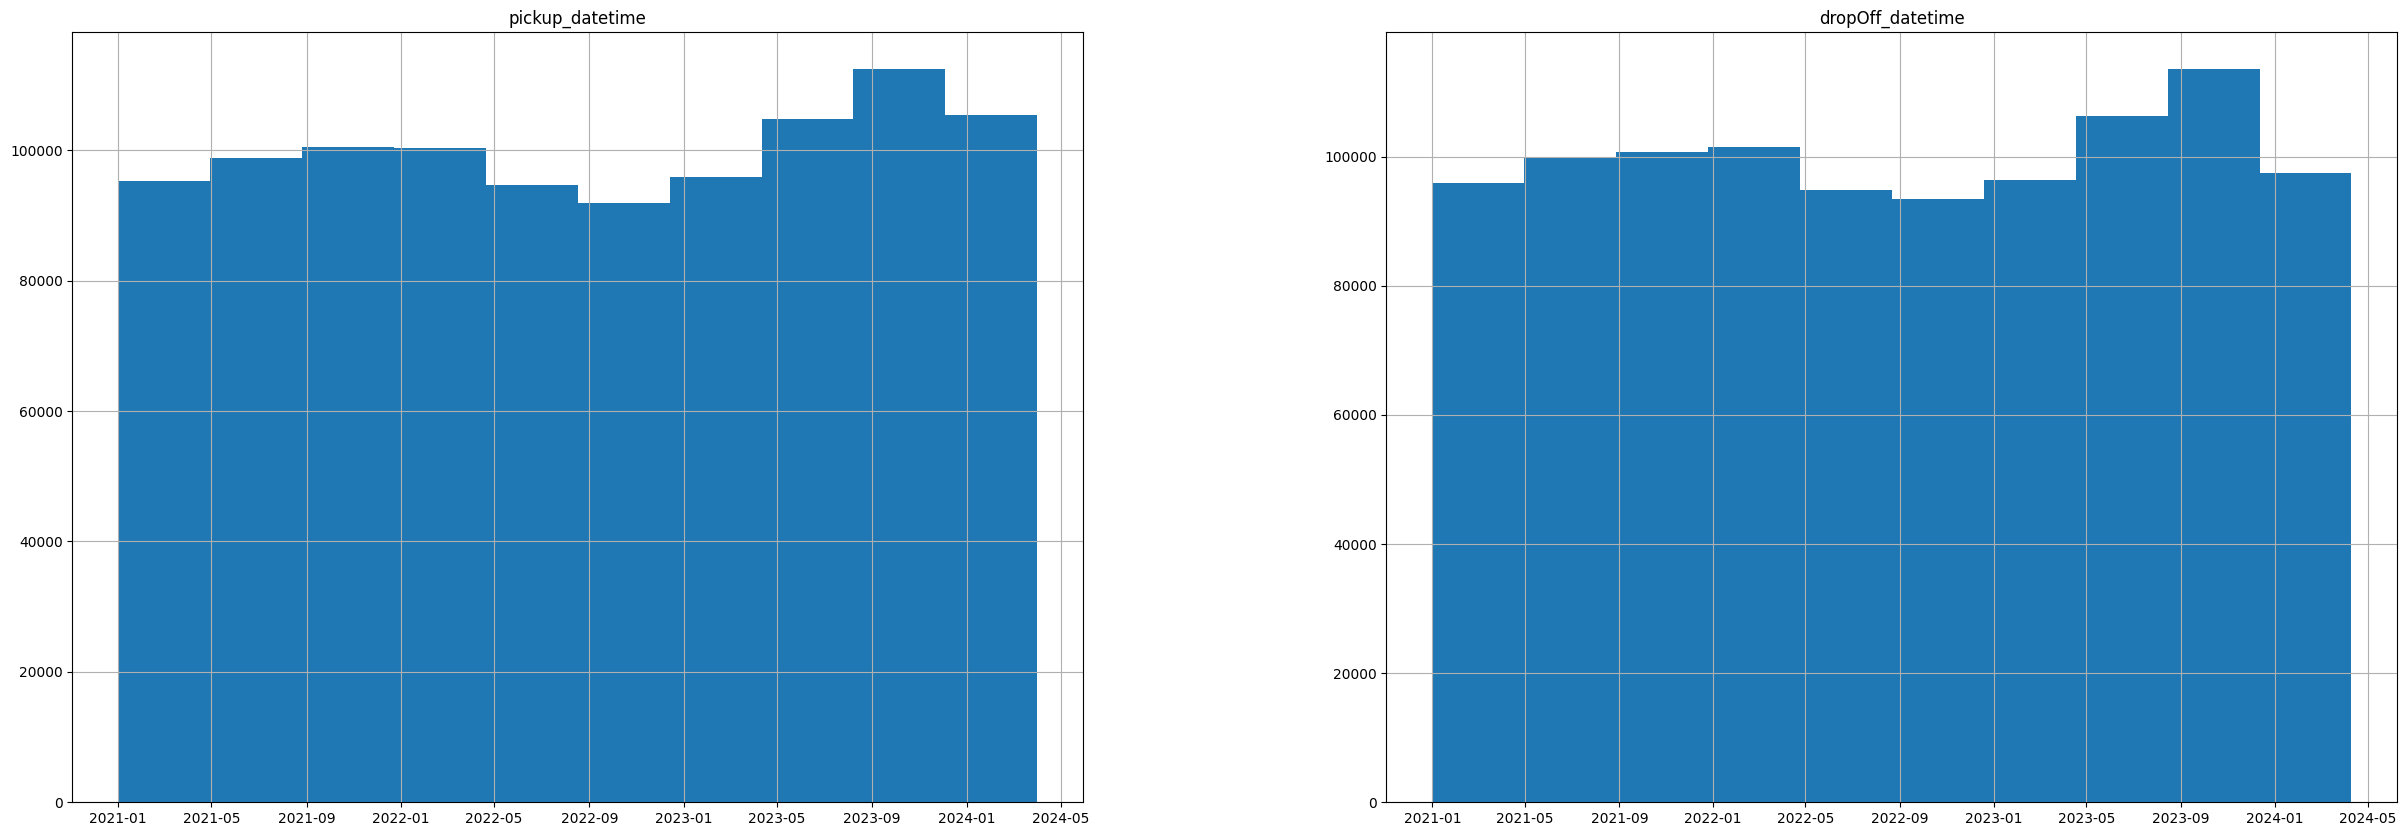

In [ ]:
df_sample.hist(figsize=(30, 10))

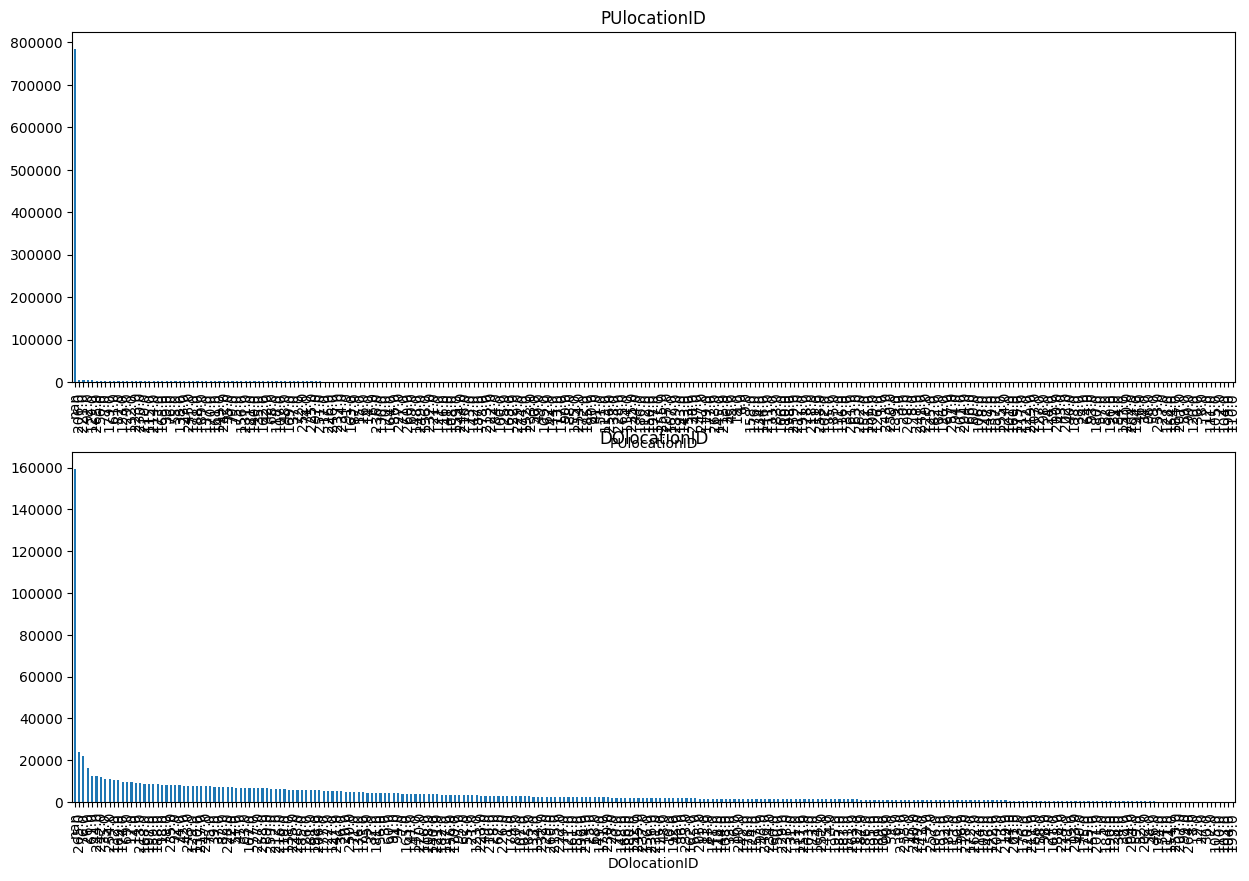

In [ ]:
# Plot categoric columns
num_rows = 2

# Create a single figure with subplots arranged in a 2-column grid
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(15, 5*num_rows))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over each column
for i, column in enumerate(category_columns):
    # Plot each bar plot on its corresponding subplot
    df_sample[column].value_counts(dropna=False).plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)

for j in range(len(category_columns), 2):
    fig.delaxes(axes[j])

plt.show()

In [ ]:
# Look once again at the summary stats table for categorical features
df_table_categoric = df[category_columns].describe().T
category_columns_perc_missing  = 100 * (df[category_columns].isnull().sum()/df.shape[0])
df_category_perc_missing = pd.DataFrame(category_columns_perc_missing, columns=['%missing'])
# cardinality
category_columns_card = df[category_columns].nunique()
df_category_card = pd.DataFrame(category_columns_card, columns=['card'])

In [ ]:
second_val = []
second_freq = []
for category in category_columns:
    # print(df[category].value_counts().index.tolist())
    second_val.append(df[category].value_counts().index.tolist()[1])
    second_freq.append(df[category].value_counts().iloc[1])

In [ ]:
# Concatenate numeric, missing and cardinality cols
df_categoric_columns_data_quality_report_table = pd.concat([df_table_categoric, df_category_perc_missing, df_category_card], axis=1)

df_categoric_columns_data_quality_report_table['second'] = second_val
df_categoric_columns_data_quality_report_table['second_freq'] = second_freq

df_categoric_columns_data_quality_report_table = df_categoric_columns_data_quality_report_table[['count', 'unique', 'top', 'freq', 'second', 'second_freq', '%missing', 'card']]
# Print data quality report table for numeric features to a file.
df_categoric_columns_data_quality_report_table.to_csv("FHV-Taxi-DataQualityReport-CategoricFeatures-Table.csv", 
                                         index_label='Feature')
df_categoric_columns_data_quality_report_table

,count,unique,top,freq,second,second_freq,%missing,card
PUlocationID,10480257.0,264.0,206.0,264094.0,221.0,236968,78.660118,264
DOlocationID,41267339.0,265.0,265.0,1176798.0,76.0,1073384,15.971512,265


In [ ]:
# Concatenate numeric, missing and cardinality cols
df_numeric_columns_data_quality_report_table = pd.concat([df_table_numeric, df_numeric_missing, df_numeric_card], axis=1)

# Print data quality report table for numeric features to a file.
df_numeric_columns_data_quality_report_table.to_csv("FHV-Taxi-DataQualityReport-NumericFeatures-Table.csv", 
                                         index_label='Feature')
df_numeric_columns_data_quality_report_table

,count,mean,min,25%,50%,75%,max,%missing,card
pickup_datetime,49111129,2022-08-28 20:49:03.576095,2021-01-01 00:00:00,2021-11-01 20:46:33,2022-08-31 07:58:00,2023-07-03 19:13:17,2024-03-31 23:59:57,0.0,33227791
dropOff_datetime,49111129,2022-08-28 21:24:30.542736,1917-09-10 21:28:24.290449,2021-11-01 21:12:24,2022-08-31 08:27:00,2023-07-03 20:10:17,2031-05-01 16:00:04,0.0,33507864


### Logical integrity tests
1. dropoff not before pickup
2. Pickup date before 2021
3. Dropoff date > 31st Mar 2024
4. Duration of taxi ride > 5hrs
5. PU location ID not an allowed value
6. DO location ID not an allowed value



In [ ]:
# Test 1: 
df[df['dropOff_datetime']<df['pickup_datetime']]

,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID
32865689,2023-03-31 20:45:33,1917-09-10 21:28:24.290449,NaN,235.0


In [ ]:
# Test 2: 
df[df['pickup_datetime']<pd.to_datetime('2021-01-01')]

,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID


In [ ]:
df[df['pickup_datetime']<pd.to_datetime('2021-01-01')].count()

pickup_datetime     0
dropOff_datetime    0
PUlocationID        0
DOlocationID        0
dtype: int64

In [ ]:
# Test 3: 
df[df['dropOff_datetime']>pd.to_datetime('2024-04-01')]

,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID
4784665,2021-05-01 15:48:11,2031-05-01 16:00:04,NaN,241.0
6227673,2021-06-05 09:30:00,2024-06-05 10:30:00,NaN,NaN
7339949,2021-07-01 05:00:00,2027-07-01 06:00:00,NaN,NaN
14549633,2021-12-24 14:00:38,2024-12-01 14:30:18,NaN,151.0
25577801,2022-09-26 22:00:00,2027-09-26 23:24:00,NaN,NaN
...,...,...,...,...
49111118,2024-03-31 23:51:59,2024-04-01 00:12:48,NaN,85.0
49111119,2024-03-31 23:36:07,2024-04-01 00:08:02,NaN,37.0
49111120,2024-03-31 23:59:00,2024-04-01 00:47:00,NaN,NaN
49111121,2024-03-31 23:36:00,2024-04-01 00:12:00,132.0,231.0


In [ ]:
late_dropoff = df[df['dropOff_datetime']>pd.to_datetime('2024-04-01')]
late_dropoff.describe().T

,count,mean,min,25%,50%,75%,max
pickup_datetime,717,2024-03-14 17:46:26.662482,2021-05-01 15:48:11,2024-03-13 16:45:00,2024-03-22 18:30:00,2024-03-31 23:42:26,2024-03-31 23:59:57
dropOff_datetime,717,2024-04-17 00:16:20.949791,2024-04-01 00:00:13,2024-04-01 00:19:00,2024-04-09 14:48:43,2024-04-09 18:42:35,2031-05-01 16:00:04


In [ ]:
# Test 4:
time_diff = pd.Timedelta(hours=5)
df[df['dropOff_datetime']-df['pickup_datetime'] > time_diff]

,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID
581,2021-01-01 00:17:19,2021-01-02 00:29:19,NaN,NaN
582,2021-01-01 00:03:31,2021-01-02 00:20:31,NaN,NaN
6350,2021-01-01 07:46:05,2021-01-01 23:37:04,NaN,NaN
6351,2021-01-01 07:08:00,2021-01-01 23:52:30,NaN,NaN
6892,2021-01-01 07:35:00,2021-01-02 07:55:00,NaN,NaN
...,...,...,...,...
49102688,2024-03-31 17:00:00,2024-04-01 01:07:00,NaN,NaN
49102699,2024-03-31 17:57:38,2024-03-31 23:02:14,NaN,NaN
49103422,2024-03-31 18:13:51,2024-03-31 23:30:20,NaN,NaN
49105810,2024-03-31 19:28:55,2024-04-01 01:55:05,NaN,NaN


In [ ]:
long_rides = df[df['dropOff_datetime']-df['pickup_datetime'] > time_diff]
long_rides['time_diff'] = long_rides['dropOff_datetime']-long_rides['pickup_datetime']
long_rides.describe().T

C:\Users\Daniel\AppData\Local\Temp\ipykernel_5600\2633472307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_rides['time_diff'] = long_rides['dropOff_datetime']-long_rides['pickup_datetime']


,count,mean,min,25%,50%,75%,max,std
pickup_datetime,126831,2022-07-28 20:03:25.134659,2021-01-01 00:03:31,2021-09-22 05:49:30.500000,2022-07-15 10:45:00,2023-05-16 15:55:00,2024-03-31 21:31:38,NaN
dropOff_datetime,126831,2022-08-01 09:16:42.453083,2021-01-01 16:12:00,2021-09-22 15:44:00,2022-07-18 18:43:09,2023-05-24 15:10:00,2031-05-01 16:00:04,NaN
time_diff,126831,3 days 13:13:17.318423,0 days 05:00:01,0 days 06:07:00,0 days 07:55:00,0 days 11:40:31,3652 days 00:11:53,29 days 06:10:42.348331


In [ ]:
# Test 7:
taxi_lookup = pd.read_csv('taxi_zone_lookup.csv')
taxi_zones = set(taxi_lookup['LocationID'])
df[~(df['PUlocationID'].isin(taxi_zones) | df['PUlocationID'].isna())]

,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID


In [ ]:
df[~(df['DOlocationID'].isin(taxi_zones) | df['DOlocationID'].isna()) ]

,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID
